In [6]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Spectral line utilities
# =========================

def alias_frequency(f_hz, fs_hz):
    """
    Fold frequency into [0, fs/2] (Nyquist zone magnitude).
    """
    f = np.abs(f_hz)
    return abs(((f + fs_hz/2) % fs_hz) - fs_hz/2)

def add_line(lines, f, amp, tol=1e-12):
    """
    Add (f, amp) into dict-like list, summing amps if same frequency (within tol).
    """
    for i, (fi, ai) in enumerate(lines):
        if abs(fi - f) < tol:
            lines[i] = (fi, ai + amp)
            return
    lines.append((f, amp))

def analog_spectrum_lines(tones, dc=0.0):
    """
    tones: list of (f0_hz, A) for A*cos(2π f0 t)
    dc: constant term (e.g., 1 means +1)
    Returns bilateral spectral lines: at ±f0 with amplitude A/2 each, and DC at 0 with amplitude dc.
    """
    lines = []
    if abs(dc) > 0:
        add_line(lines, 0.0, dc)
    for f0, A in tones:
        add_line(lines, +float(f0), A/2.0)
        add_line(lines, -float(f0), A/2.0)
    return sorted(lines, key=lambda x: x[0])

def sampled_spectrum_lines(analog_lines, fs_hz, fmax_hz, replicate_dc=False):
    """
    Replicate analog spectral lines every fs (bilateral), keeping only those within [-fmax, +fmax].

    replicate_dc=False  ==> DC (0 Hz) is kept ONLY at 0 Hz (not at ±k*fs).
    """
    fmin = -abs(fmax_hz)
    fmax = +abs(fmax_hz)

    lines = []

    for f0, amp in analog_lines:
        f0 = float(f0)

        # Find all k such that f0 + k*fs is inside [fmin, fmax]
        k_low  = int(np.ceil((fmin - f0) / fs_hz))
        k_high = int(np.floor((fmax - f0) / fs_hz))

        for k in range(k_low, k_high + 1):
            # Do NOT replicate DC to ±k*fs
            if (abs(f0) < 1e-12) and (not replicate_dc) and (k != 0):
                continue

            f_rep = f0 + k * fs_hz
            add_line(lines, f_rep, amp)

    return sorted(lines, key=lambda x: x[0])

def ideal_lpf(lines, fc_hz):
    """Keep only lines within |f| <= fc."""
    fc = abs(fc_hz)
    return [(f, a) for (f, a) in lines if abs(f) <= fc + 1e-12]

def plot_bilateral_lines(lines, fmax_hz, title):
    """
    Bilateral stem plot from -fmax to +fmax.
    """
    freqs = np.array([f for f, _ in lines], dtype=float)
    amps  = np.array([a for _, a in lines], dtype=float)

    plt.figure(figsize=(12, 4))
    plt.stem(freqs, amps, basefmt=" ")
    plt.axvline(0, linewidth=1)
    plt.xlim([-abs(fmax_hz), +abs(fmax_hz)])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Line amplitude")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

def print_lines(lines, name):
    print(f"\n{name} (bilateral lines):")
    for f, a in lines:
        print(f"  f = {f:>8.1f} Hz   amp = {a:.6g}")



Q1(a) Original analog spectrum X(f) (bilateral lines):
  f =  -1000.0 Hz   amp = 2.5
  f =   1000.0 Hz   amp = 2.5


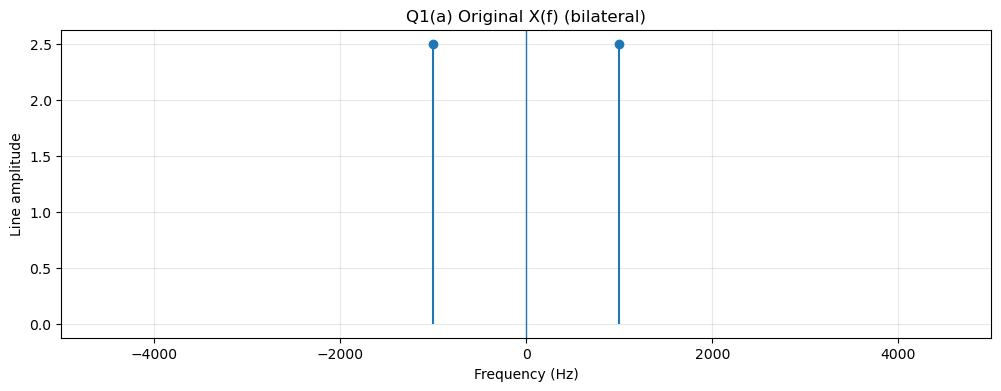


Q1(b) Sampled spectrum Xs(f) within ±20 kHz (bilateral lines):
  f = -17000.0 Hz   amp = 2.5
  f = -15000.0 Hz   amp = 2.5
  f =  -9000.0 Hz   amp = 2.5
  f =  -7000.0 Hz   amp = 2.5
  f =  -1000.0 Hz   amp = 2.5
  f =   1000.0 Hz   amp = 2.5
  f =   7000.0 Hz   amp = 2.5
  f =   9000.0 Hz   amp = 2.5
  f =  15000.0 Hz   amp = 2.5
  f =  17000.0 Hz   amp = 2.5


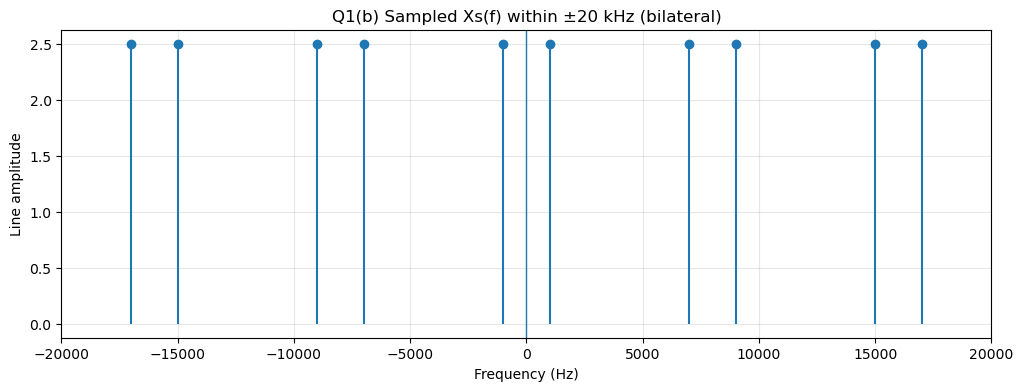

In [7]:
fs = 8000.0

# Q1: original
tones_q1 = [(1000.0, 5.0)]
Xa_q1 = analog_spectrum_lines(tones_q1, dc=0.0)
print_lines(Xa_q1, "Q1(a) Original analog spectrum X(f)")
plot_bilateral_lines(Xa_q1, fmax_hz=5000, title="Q1(a) Original X(f) (bilateral)")

# Q1: sampled spectrum, show up to 20 kHz (bilateral => ±20 kHz)
Xs_q1 = sampled_spectrum_lines(Xa_q1, fs_hz=fs, fmax_hz=20000, replicate_dc=False)
print_lines(Xs_q1, "Q1(b) Sampled spectrum Xs(f) within ±20 kHz")
plot_bilateral_lines(Xs_q1, fmax_hz=20000, title="Q1(b) Sampled Xs(f) within ±20 kHz (bilateral)")



Q2(a) Sampled spectrum within ±20 kHz (bilateral lines):
  f = -19000.0 Hz   amp = 1.5
  f = -18000.0 Hz   amp = 2.5
  f = -14000.0 Hz   amp = 2.5
  f = -13000.0 Hz   amp = 1.5
  f = -11000.0 Hz   amp = 1.5
  f = -10000.0 Hz   amp = 2.5
  f =  -6000.0 Hz   amp = 2.5
  f =  -5000.0 Hz   amp = 1.5
  f =  -3000.0 Hz   amp = 1.5
  f =  -2000.0 Hz   amp = 2.5
  f =   2000.0 Hz   amp = 2.5
  f =   3000.0 Hz   amp = 1.5
  f =   5000.0 Hz   amp = 1.5
  f =   6000.0 Hz   amp = 2.5
  f =  10000.0 Hz   amp = 2.5
  f =  11000.0 Hz   amp = 1.5
  f =  13000.0 Hz   amp = 1.5
  f =  14000.0 Hz   amp = 2.5
  f =  18000.0 Hz   amp = 2.5
  f =  19000.0 Hz   amp = 1.5


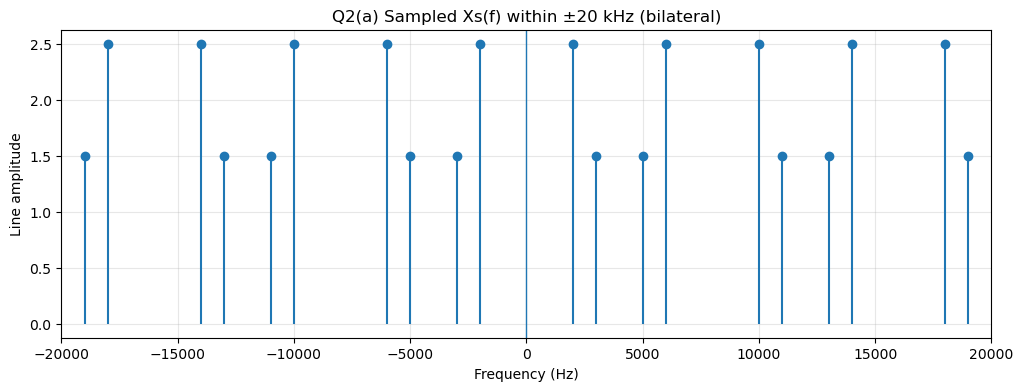


Q2(b) Recovered spectrum after ideal LPF (fc=4 kHz) (bilateral lines):
  f =  -3000.0 Hz   amp = 1.5
  f =  -2000.0 Hz   amp = 2.5
  f =   2000.0 Hz   amp = 2.5
  f =   3000.0 Hz   amp = 1.5


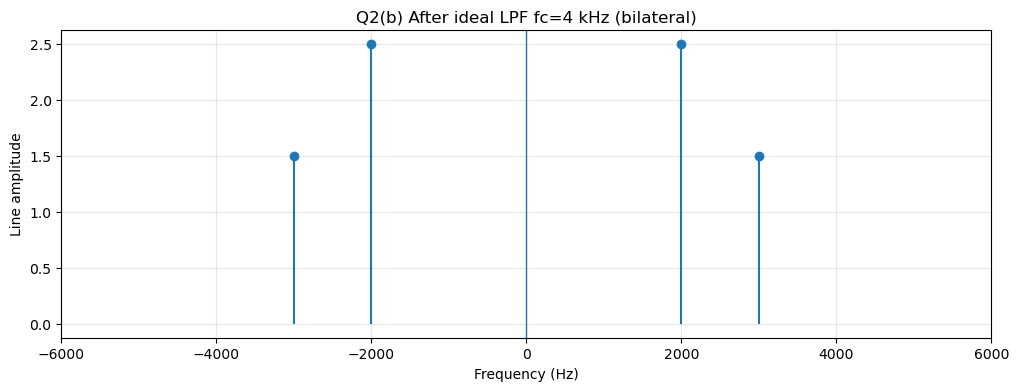

In [8]:
# Q2: analog
tones_q2 = [(2000.0, 5.0), (3000.0, 3.0)]
Xa_q2 = analog_spectrum_lines(tones_q2, dc=0.0)

# Q2(a): sampled up to 20 kHz (bilateral)
Xs_q2 = sampled_spectrum_lines(Xa_q2, fs_hz=fs, fmax_hz=20000, replicate_dc=False)
print_lines(Xs_q2, "Q2(a) Sampled spectrum within ±20 kHz")
plot_bilateral_lines(Xs_q2, fmax_hz=20000, title="Q2(a) Sampled Xs(f) within ±20 kHz (bilateral)")

# Q2(b): recovered spectrum with ideal LPF fc=4 kHz
Y_q2 = ideal_lpf(Xs_q2, fc_hz=4000.0)
print_lines(Y_q2, "Q2(b) Recovered spectrum after ideal LPF (fc=4 kHz)")
plot_bilateral_lines(Y_q2, fmax_hz=6000, title="Q2(b) After ideal LPF fc=4 kHz (bilateral)")


Q3(a) Sampled spectrum within ±20 kHz (bilateral lines):
  f = -18000.0 Hz   amp = 2.5
  f = -14000.0 Hz   amp = 2.5
  f = -13000.0 Hz   amp = 0.5
  f = -11000.0 Hz   amp = 0.5
  f = -10000.0 Hz   amp = 2.5
  f =  -6000.0 Hz   amp = 2.5
  f =  -5000.0 Hz   amp = 0.5
  f =  -3000.0 Hz   amp = 0.5
  f =  -2000.0 Hz   amp = 2.5
  f =   2000.0 Hz   amp = 2.5
  f =   3000.0 Hz   amp = 0.5
  f =   5000.0 Hz   amp = 0.5
  f =   6000.0 Hz   amp = 2.5
  f =  10000.0 Hz   amp = 2.5
  f =  11000.0 Hz   amp = 0.5
  f =  13000.0 Hz   amp = 0.5
  f =  14000.0 Hz   amp = 2.5
  f =  18000.0 Hz   amp = 2.5


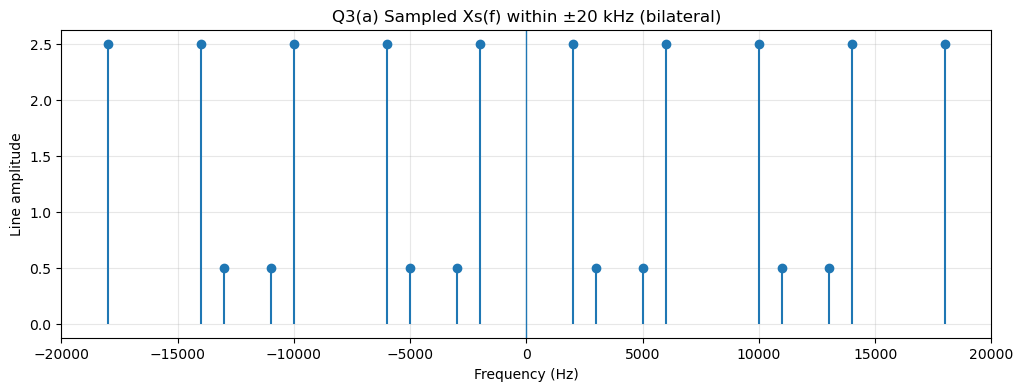


Q3(b) After ideal LPF fc=4 kHz (bilateral) (bilateral lines):
  f =  -3000.0 Hz   amp = 0.5
  f =  -2000.0 Hz   amp = 2.5
  f =   2000.0 Hz   amp = 2.5
  f =   3000.0 Hz   amp = 0.5


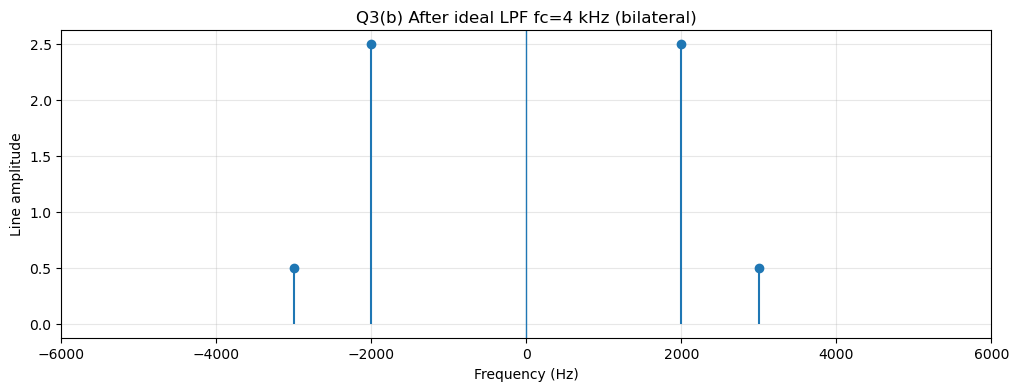


Aliasing check (fs=8kHz):
  tone   2000 Hz -> alias at 2000 Hz
  tone   5000 Hz -> alias at 3000 Hz


In [4]:
tones_q3 = [(2000.0, 5.0), (5000.0, 1.0)]
Xa_q3 = analog_spectrum_lines(tones_q3, dc=0.0)

# Q3(a): sampled up to 20 kHz (bilateral)
Xs_q3 = sampled_spectrum_lines(Xa_q3, fs_hz=fs, fmax_hz=20000, replicate_dc=False)
print_lines(Xs_q3, "Q3(a) Sampled spectrum within ±20 kHz")
plot_bilateral_lines(Xs_q3, fmax_hz=20000, title="Q3(a) Sampled Xs(f) within ±20 kHz (bilateral)")

# Q3(b): recovered with LPF fc=4 kHz
Y_q3 = ideal_lpf(Xs_q3, fc_hz=4000.0)
print_lines(Y_q3, "Q3(b) After ideal LPF fc=4 kHz (bilateral)")
plot_bilateral_lines(Y_q3, fmax_hz=6000, title="Q3(b) After ideal LPF fc=4 kHz (bilateral)")

# Show aliasing of 5 kHz at fs=8 kHz
print("\nAliasing check (fs=8kHz):")
for f0, _A in tones_q3:
    print(f"  tone {f0:>6.0f} Hz -> alias at {alias_frequency(f0, fs):.0f} Hz")


Q4(a) Original analog spectrum X(f) (bilateral lines):
  f =  -6000.0 Hz   amp = 1.5
  f =  -4000.0 Hz   amp = 1
  f =  -2000.0 Hz   amp = 0.5
  f =      0.0 Hz   amp = 1
  f =   2000.0 Hz   amp = 0.5
  f =   4000.0 Hz   amp = 1
  f =   6000.0 Hz   amp = 1.5


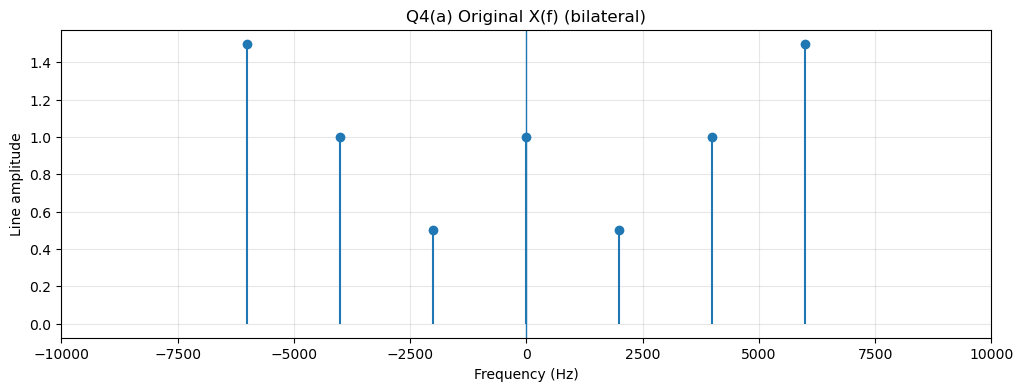


Q4(c) Sampled spectrum within ±40 kHz (DC not replicated) (bilateral lines):
  f = -22000.0 Hz   amp = 1.5
  f = -20000.0 Hz   amp = 1
  f = -18000.0 Hz   amp = 0.5
  f = -14000.0 Hz   amp = 2
  f = -12000.0 Hz   amp = 2
  f = -10000.0 Hz   amp = 2
  f =  -6000.0 Hz   amp = 2
  f =  -4000.0 Hz   amp = 2
  f =  -2000.0 Hz   amp = 2
  f =      0.0 Hz   amp = 1
  f =   2000.0 Hz   amp = 2
  f =   4000.0 Hz   amp = 2
  f =   6000.0 Hz   amp = 2
  f =  10000.0 Hz   amp = 2
  f =  12000.0 Hz   amp = 2
  f =  14000.0 Hz   amp = 2
  f =  18000.0 Hz   amp = 0.5
  f =  20000.0 Hz   amp = 1
  f =  22000.0 Hz   amp = 1.5


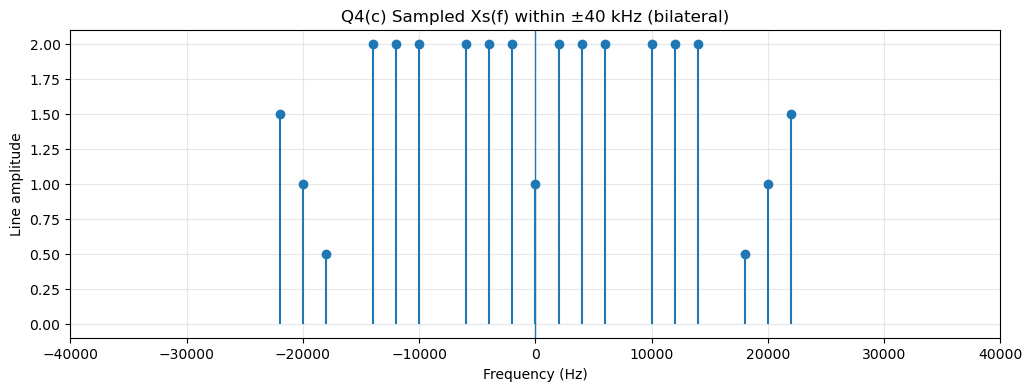


Q4(e) Aliasing frequencies (folded to [0, fs/2]):
  tone   2000 Hz (A=1.0) -> alias at 2000 Hz
  tone   4000 Hz (A=2.0) -> alias at 4000 Hz
  tone   6000 Hz (A=3.0) -> alias at 2000 Hz

Q4(f) After ideal LPF fc=6 kHz (bilateral) (bilateral lines):
  f =  -6000.0 Hz   amp = 2
  f =  -4000.0 Hz   amp = 2
  f =  -2000.0 Hz   amp = 2
  f =      0.0 Hz   amp = 1
  f =   2000.0 Hz   amp = 2
  f =   4000.0 Hz   amp = 2
  f =   6000.0 Hz   amp = 2


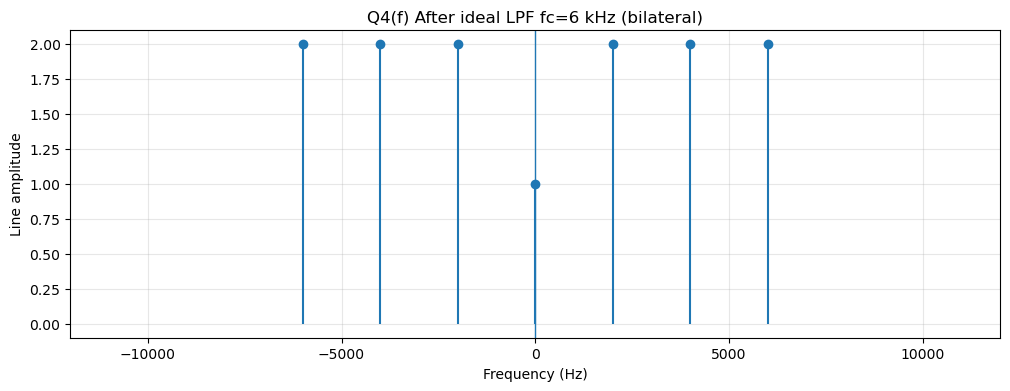

In [5]:
tones_q4 = [(2000.0, 1.0), (4000.0, 2.0), (6000.0, 3.0)]
dc_q4 = 1.0

# Q4(a): original analog spectrum (bilateral)
Xa_q4 = analog_spectrum_lines(tones_q4, dc=dc_q4)
print_lines(Xa_q4, "Q4(a) Original analog spectrum X(f)")
plot_bilateral_lines(Xa_q4, fmax_hz=10000, title="Q4(a) Original X(f) (bilateral)")

# Q4(c): sampled spectrum, bilateral up to 40 kHz
Xs_q4 = sampled_spectrum_lines(Xa_q4, fs_hz=fs, fmax_hz=40000, replicate_dc=False)
print_lines(Xs_q4, "Q4(c) Sampled spectrum within ±40 kHz (DC not replicated)")
plot_bilateral_lines(Xs_q4, fmax_hz=40000, title="Q4(c) Sampled Xs(f) within ±40 kHz (bilateral)")

# Q4(e): aliasing frequencies
print("\nQ4(e) Aliasing frequencies (folded to [0, fs/2]):")
for f0, A in tones_q4:
    print(f"  tone {f0:>6.0f} Hz (A={A}) -> alias at {alias_frequency(f0, fs):.0f} Hz")

# Q4(f): recovered with ideal LPF fc=6 kHz
Y_q4 = ideal_lpf(Xs_q4, fc_hz=6000.0)
print_lines(Y_q4, "Q4(f) After ideal LPF fc=6 kHz (bilateral)")
plot_bilateral_lines(Y_q4, fmax_hz=12000, title="Q4(f) After ideal LPF fc=6 kHz (bilateral)")